# Install PySyft and Download SARS-COV-2 Dataset

In [ ]:
! pip install syft==0.2.9

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset

 89% 205M/230M [00:01<00:00, 103MB/s]
100% 230M/230M [00:02<00:00, 115MB/s]


In [ ]:
! unzip sarscov2-ctscan-dataset.zip

# Implementation

In [1]:
# import 
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import syft as sy

from torch import nn

from utils.config import *
from utils.utils import *
from utils.splitNN import *
from utils.generator import *

In [2]:
# Initilize hook
hook = sy.TorchHook(torch)

In [3]:
# Initilize arguments
args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

torch.manual_seed(args.seed)
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [ ]:
# Check working device
device

In [5]:
# Initilize Models and their Optimizers
models = splitModels(args)
optimizers = splitOptimizers(models, args)

In [6]:
# Create some workers
alice = sy.VirtualWorker(hook, id="alice")
bob = sy.VirtualWorker(hook, id="bob")
claire = sy.VirtualWorker(hook, id="claire")

# Send Model Segments to model locations
model_locations = [alice, bob, claire]
for model, location in zip(models, model_locations):
    model.send(location)

In [7]:
# Instantiate a SpliNN class for our models and their optimizers
splitNN = SplitNN(models, optimizers)

In [8]:
# Initialize Dataset Generator
dataGen = DatasetLoader(DATA_DIR, args)

In [9]:
# Generate Training and Testing Dataset Loader
trainDatasetLoader = dataGen.generateTrainDataset()
testDatasetLoader = dataGen.generateTestDataset()

[INFO] Generating Training Dataset Loader ...
[INFO] Total number of images for training dataset: 1984
[INFO] Generating Testing Dataset Loader ...
[INFO] Total number of images for testing dataset: 497


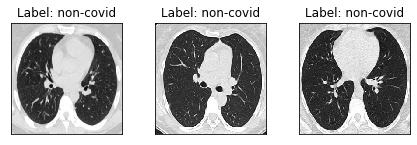

In [16]:
# plot images
plotImages(trainDatasetLoader)

In [10]:
# Initialize lists to capture train and test loss
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainDatasetLoader.dataset) for i in range(args.epochs + 1)]

In [11]:
# train function
def train(epoch):

    for batch_idx, (images, labels) in enumerate(trainDatasetLoader):
        # send data to model's location
        images = images.send(models[0].location)
        images = images.view(images.shape[0], -1)
        labels = labels.send(models[-1].location)

        # Zero our grads
        splitNN.zero_grads()
        # Make a prediction
        pred = splitNN.forward(images)
        # Calculate loss
        criterion = nn.NLLLoss()
        loss = criterion(pred, labels)
        # Backpropagate
        loss.backward()
        # Feed Gradients backward through the network
        splitNN.backward()
        # Update the weights
        splitNN.step()

        # Get loss value
        train_loss = loss.get().item()

        if batch_idx % args.log_interval == 0:
            # print stats
            print('Train Epoch: {}\t[{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch+1, batch_idx * len(images), len(trainDatasetLoader.dataset),
            100. * batch_idx / len(trainDatasetLoader), train_loss))
            
            # append loss values
            train_counter.append(
                (batch_idx*args.batch_size) + ((epoch)*len(trainDatasetLoader.dataset)))
            train_losses.append(train_loss)

In [12]:
# test function
def test(epoch):

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for images, labels in testDatasetLoader:
            # send data to model's location
            images = images.send(models[0].location)
            images = images.view(images.shape[0], -1)

            # generate predictions
            output = splitNN.forward(images).get()

            # calculate stats
            test_loss += F.nll_loss(output, labels, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).sum()

        test_loss /= len(testDatasetLoader.dataset)
        test_losses.append(test_loss)

        # print stats
        print('\nTest Epoch: {}, Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch+1, test_loss, correct, len(testDatasetLoader.dataset),
        100. * correct / len(testDatasetLoader.dataset)))

In [13]:
# training
test(epoch=-1)
for epoch in range(args.epochs):
    train_loss = train(epoch)
    test(epoch)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test Epoch: 1, Avg. loss: 0.6938, Accuracy: 251/497 (51%)

Train Epoch: 1	[0/1984 (0%)]	Loss: 0.694470
Train Epoch: 1	[1280/1984 (62%)]	Loss: 0.681708

Test Epoch: 1, Avg. loss: 0.6841, Accuracy: 257/497 (52%)

Train Epoch: 2	[0/1984 (0%)]	Loss: 0.682156
Train Epoch: 2	[1280/1984 (62%)]	Loss: 0.673483

Test Epoch: 2, Avg. loss: 0.6689, Accuracy: 329/497 (66%)

Train Epoch: 3	[0/1984 (0%)]	Loss: 0.686858
Train Epoch: 3	[1280/1984 (62%)]	Loss: 0.657601

Test Epoch: 3, Avg. loss: 0.6548, Accuracy: 350/497 (70%)

Train Epoch: 4	[0/1984 (0%)]	Loss: 0.663381
Train Epoch: 4	[1280/1984 (62%)]	Loss: 0.646193

Test Epoch: 4, Avg. loss: 0.6712, Accuracy: 268/497 (54%)

Train Epoch: 5	[0/1984 (0%)]	Loss: 0.657150
Train Epoch: 5	[1280/1984 (62%)]	Loss: 0.641865

Test Epoch: 5, Avg. loss: 0.6349, Accuracy: 355/497 (71%)

Train Epoch: 6	[0/1984 (0%)]	Loss: 0.633402
Train Epoch: 6	[1280/1984 (62%)]	Loss: 0.638051

Test Epoch: 6, Avg. loss: 0.6250, Accuracy: 363/497 (73%)

Train Epoch: 7	[0/1984 (0%)]

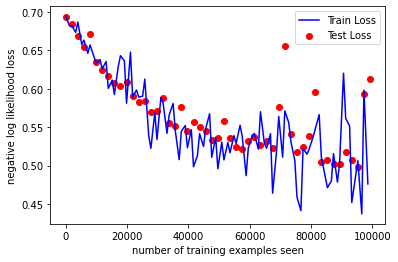

In [17]:
# plot train and test loss
plotLoss(train_counter, train_losses, 
    test_counter, test_losses, PLOT_PATH)